# Sistemas de Recomendação

Os dois tipos mais comuns de sistemas de recomendação são **conteúdo-dependente** e **filtragem colaborativa**.
* A filtragem colaborativa produz recomendações baseadas no conhecimento das atitudes em relação aos itens. Tal método usa o "conhecimento da massa" para recomendar itens. O algoritmo da filtragem colaborativa também tem a capacidade de aprender por si só, o que significa que pode começar a aprender quais parâmetros usar. Existem dois tipos de filtragem:
    * filtragem colaborativa por memória
    * filtragem colaborativa por modelo (será implementado nesse notebook)

Tal sistema fará uso de decomposição singular de valor e computando a similaridade do coseno.

* Sistemas baseados em conteúdo são sistemas que focam nos atributos dos itens e dão recomendações baseadas nas similaridades dos mesmos.

In [1]:
import numpy as np
import pandas as pd


In [2]:
column_names=['user_id','item_id','rating','timestamp']
df = pd.read_csv("u.data", sep='\t', names=column_names)

In [3]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100003 non-null  int64
 1   item_id    100003 non-null  int64
 2   rating     100003 non-null  int64
 3   timestamp  100003 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [5]:
movie_title = pd.read_csv('Movie_Id_Titles')
movie_title.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [8]:
comb_df = pd.merge(df, movie_title, on='item_id')
comb_df

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)
...,...,...,...,...,...
99998,840,1674,4,891211682,Mamma Roma (1962)
99999,655,1640,3,888474646,"Eighth Day, The (1996)"
100000,655,1637,3,888984255,Girls Town (1996)
100001,655,1630,3,887428735,"Silence of the Palace, The (Saimt el Qusur) (1..."


## Análise exploratória de dados

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [16]:
comb_df.groupby('title')['rating'].mean()

title
'Til There Was You (1997)                2.333333
1-900 (1994)                             2.600000
101 Dalmatians (1996)                    2.908257
12 Angry Men (1957)                      4.344000
187 (1997)                               3.024390
                                           ...   
Young Guns II (1990)                     2.772727
Young Poisoner's Handbook, The (1995)    3.341463
Zeus and Roxanne (1997)                  2.166667
unknown                                  3.444444
Á köldum klaka (Cold Fever) (1994)       3.000000
Name: rating, Length: 1664, dtype: float64

In [17]:
comb_df.groupby('title')['rating'].mean().nunique()

896

In [18]:
comb_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
They Made Me a Criminal (1939)                       5.0
Marlene Dietrich: Shadow and Light (1996)            5.0
Saint of Fort Washington, The (1993)                 5.0
Someone Else's America (1995)                        5.0
Star Kid (1997)                                      5.0
Great Day in Harlem, A (1994)                        5.0
Aiqing wansui (1994)                                 5.0
Santa with Muscles (1996)                            5.0
Prefontaine (1997)                                   5.0
Entertaining Angels: The Dorothy Day Story (1996)    5.0
Name: rating, dtype: float64

In [19]:
comb_df.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
Star Wars (1977)                 584
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: rating, dtype: int64

* Como definir os melhores filmes? Só olhando para a média ou para os filmes mais vistos não conseguimos ter uma ideia precisa, então iremos juntar essas duas informações

In [20]:
ratings = pd.DataFrame(comb_df.groupby('title')['rating'].mean())

In [21]:
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [23]:
ratings['count'] = pd.DataFrame(comb_df.groupby('title')['rating'].count())

In [24]:
ratings.head()

,rating,count
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


<AxesSubplot:>

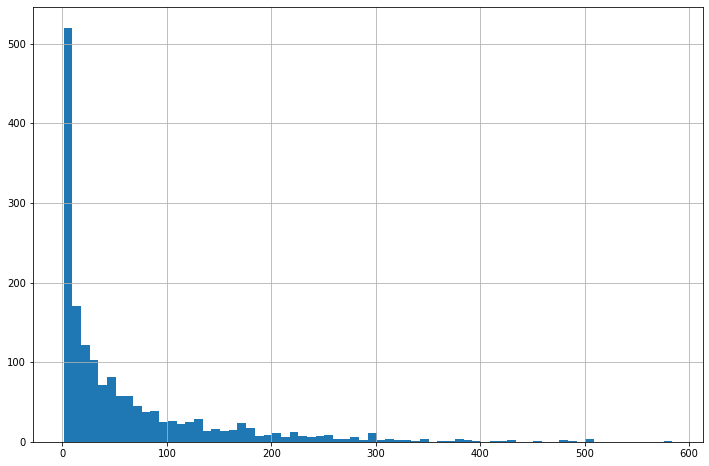

In [26]:
plt.figure(figsize=(12,8))
ratings['count'].hist(bins=70)

* Poucos filmes foram vistos por muitos usuários, a grande maioria dos filmes foi vista poucas vezes

<AxesSubplot:>

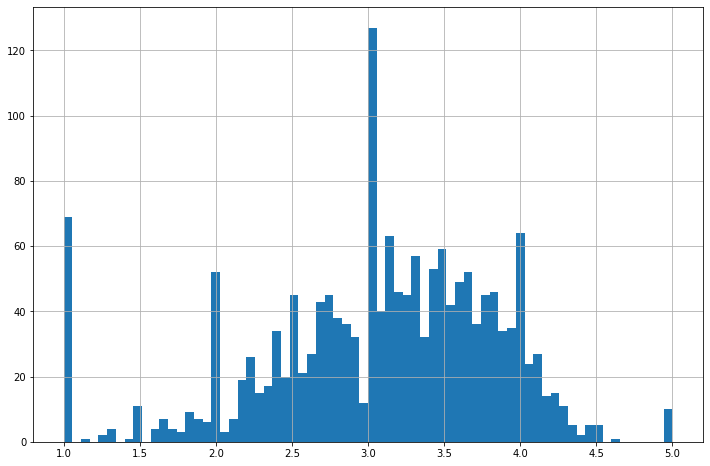

In [27]:
plt.figure(figsize=(12,8))
ratings['rating'].hist(bins=70)

* Os filmes com rates 1.0, 2.0, 3.0, 4.0 e 5.0 provavelmente foram avaliados apenas uma única vez.
* A maioria dos filmes tem rating em torno de 3.0, 3.5

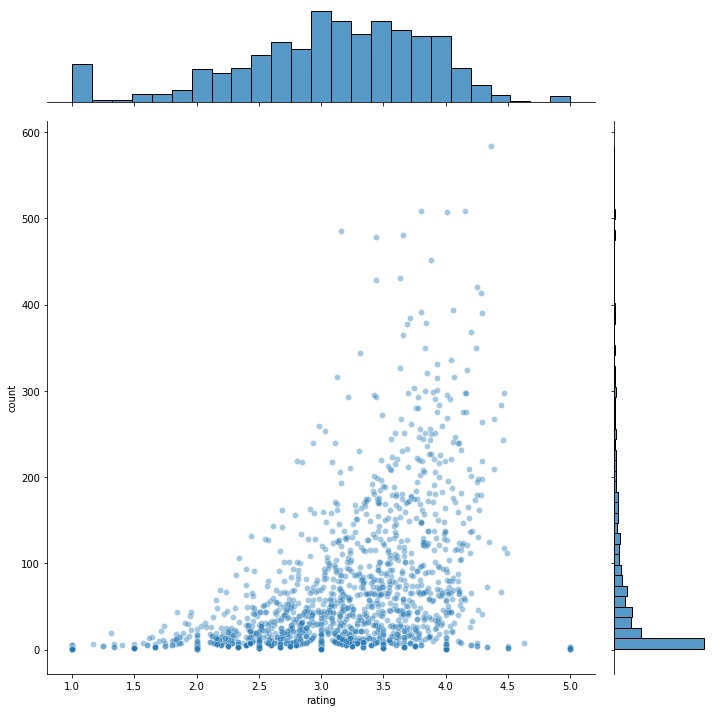

In [38]:
sns.jointplot(x='rating', y='count', data=ratings, alpha=.4, height=10)

* Vemos que temos um aumento da média conforme o filme é mais visto. O que se é esperado pois os filmes mais vistos geralmente são melhores, e por isso o rating dele é maior

In [39]:
moviematrix = comb_df.pivot_table(index='user_id', columns='title', values='rating')

In [40]:
moviematrix.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
ratings.sort_values('count', ascending=False)

,rating,count
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
...,...,...
"Great Day in Harlem, A (1994)",5.000000,1
"Other Voices, Other Rooms (1997)",3.000000,1
Good Morning (1971),1.000000,1


In [42]:
starwars_user_ratings = moviematrix['Star Wars (1977)']

In [43]:
starwars_user_ratings

user_id
0      5.0
1      5.0
2      5.0
3      NaN
4      5.0
      ... 
939    NaN
940    4.0
941    NaN
942    5.0
943    4.0
Name: Star Wars (1977), Length: 944, dtype: float64

In [45]:
liar_user_ratings = moviematrix['Liar Liar (1997)']
liar_user_ratings

user_id
0      NaN
1      NaN
2      1.0
3      2.0
4      5.0
      ... 
939    NaN
940    4.0
941    4.0
942    NaN
943    NaN
Name: Liar Liar (1997), Length: 944, dtype: float64

In [46]:
similar_to_starwars = moviematrix.corrwith(starwars_user_ratings)

/home/guilherme/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/guilherme/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [47]:
similar_to_starwars.head()

title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

* Esses valores nos da a semelhança entre as duas séries de filme, de notas de quem assistiu SW e quem assistiu esses filmes

In [48]:
similar_to_liar = moviematrix.corrwith(liar_user_ratings)

/home/guilherme/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/guilherme/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [49]:
similar_to_liar.head()

title
'Til There Was You (1997)    0.118913
1-900 (1994)                      NaN
101 Dalmatians (1996)        0.469765
12 Angry Men (1957)          0.066272
187 (1997)                   0.175145
dtype: float64

## Avaliação dos filmes semelhante ao Star Wars

In [50]:
corr_starwars = pd.DataFrame(similar_to_starwars, columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


In [51]:
corr_starwars.sort_values('Correlation', ascending=False).head()

,Correlation
title,
Hollow Reed (1996),1.0
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0


* Os usuários deram a mesma nota nesses filmes e no Star Wars (1977)

In [52]:
corr_starwars = corr_starwars.join(ratings['count'])
corr_starwars.head()

,Correlation,count
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


* Vamos fazer um filtro para pegar apenas os filmes que foram avaliados por no máximo 100 pessoas

In [54]:
corr_starwars[corr_starwars['count']>100].sort_values('Correlation', ascending=False).head()

,Correlation,count
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


* vemos que a avaliação que as pessoas tiveram para Star Wars (1977) foi semelhante ao "Empire Strikes Back", "Return of the Jedi", e etc

## Avaliação de filmes semelhante ao Liar Liar

In [55]:
corr_liar = pd.DataFrame(similar_to_liar, columns=['Correlation'])
corr_liar.dropna(inplace=True)
corr_liar.head()
corr_liar = corr_liar.join(ratings['count'])
corr_liar[corr_liar['count']>100].sort_values('Correlation', ascending=False).head()

,Correlation,count
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
